# 2. Extended Stochastic Example


This example extends the [Simple Stochastic Example](savings_example1.ipynb), and reflects fee collection, policy decrement, GMDB payouts and dynamic lapse rates.


The [Simple Stochastic Example](savings_example1.ipynb) shows how TVOGs on GMADB policies can be calculated by two different methods, the Black-Scholes-Merton formula and Monte-Carlo simulations with risk neutral scenarios. 
However, the example is too simplified to be practical. 
It does not consider fees on account value and policy decrement.
This example considers the effect of the fee collection and policy decrement.
Futhurmore, this example introduces a simple dynamic lapse assumption to make GMAB pay-offs path dependent.


## Change summary


The model for this example is developed by updating `CashValue_ME_EX1`, named `CashValue_ME_EX2` and included in the ``basiclife`` library.

The following page shows a complete comparison of formulas in the `Projection` space between `CashValue_ME_EX1` and `CashValue_ME_EX2` with highlights on updated parts.

https://www.diffchecker.com/5QHCTyll


The following cells are newly added in `CashValue_ME_EX2`.

* `csv_pp`: Cash surrender value per policy
* `has_fees`: A switch to turn maintenance fees on and off
* `has_mortality`: A switch to turn mortality decrement on and off
* `has_lapse`: A switch to turn lapse decrement on and off
* `is_lapse_dynamic`: A switch to turn dynamic lapse factor on and off
* `monte_carlo`: A summary table showing the time values of guarantees and present value of fees
* `pv_maint_fee`: Present value of maintenance fees deducted from account value

To specify simulation configurations, following references are newly added.

* `sim_param_table`: A DataFrame containing configuration parameter combinations by simulation
* `sim_id`: Selected simulation ID


The formulas of the following cells are updated from `CashValue_ME_EX1`.

* `formula_option_put`: Paramter $q$ is introduced to denote continuous dividend yield.
* `lapse_rate`: Base lapses are updated and a dynamic factor is considered
* `maint_fee_rate`: Fee deduction can now be activated/deactivated
* `mort_rate`: Mortality rates are replaced

Following input data is updated.

* `model_point`, `model_point_1`: `age_at_entry` is now all 70.
* `mort_table`:  New rates are taken from [the 2019 period life table for the Social Security area population in US](https://www.ssa.gov/oact/STATS/table4c6.html)

`Projection` space is now parameterized with `sim_id`.

`Summary`, a new space to summarize the results of `Projection` with various `sim_id` is introduced.


The following sections discuss in more details each change made on `CashValue_ME_EX1` to develop `CashValue_ME_EX2`.


The code below imports essential modules, reads the `CashValue_ME_EX2` model into Python, and defines `proj` as an alias for the `Projection` space for convenience. 

In [1]:
import numpy as np
import pandas as pd
import modelx as mx

model = mx.read_model('CashValue_ME_EX2')
proj = model.Projection

## Simulation patterns

Switches are introduced to activage/deactivate changes made in this example to make it easy to examine the impact of each change. The list below shows the switches and what they control:

* `has_fees`: Whether to deduct maintenance fees from account value
* `has_mortality`: Whether to reflect mortality decrement
* `has_lapse`: Whether to reflect lapse decrement
* `is_lapse_dynamic`: Whether to make lapse assumption dynamic

The `sim_param_table` DataFrame table defines 5 Simulation IDs from 1 through 5. The first simulation, which is obtained by setting 1 to `sim_id`, reproduces the result from the `CashValue_ME_EX1` model. Each of the follwoing simulation turns on one change on top of the previous simulation. 


In [2]:
proj.sim_param_table

,has_fees,has_mortality,has_lapse,is_lapse_dynamic
sim_id,,,,
1,False,False,False,False
2,True,False,False,False
3,True,True,False,False
4,True,True,True,False
5,True,True,True,True


The cells representing the switches refer to the `sim_param_table` and pick up boolean values based on the value of `sim_id`.

In [3]:
proj.has_fees.formula

def has_fees():
    return sim_param_table['has_fees'][sim_id]

In [4]:
proj.has_mortality.formula

def has_mortality():
    return sim_param_table['has_mortality'][sim_id]

In [5]:
proj.has_lapse.formula

def has_lapse():
    return sim_param_table['has_lapse'][sim_id]

In [6]:
proj.is_lapse_dynamic.formula

def is_lapse_dynamic():
    return sim_param_table['is_lapse_dynamic'][sim_id]

By default, 1 is set to `sim_id` so all the switches are deactivated.

In [7]:
proj.sim_id

1

In [8]:
proj.has_fees(),  proj.has_mortality(), proj.has_lapse() ,proj.is_lapse_dynamic()

(False, False, False, False)

## Reflecting maintenance fees

For simplicity, the `CashValue_ME_EX1` model in the [Simple Stochastic Example](savings_example1.ipynb) omits maintenance fees on account value.
In this example, we assume the maintenance fees are deducted from account value at a constant rate of 1% per annum.

The [Simple Stochastic Example](savings_example1.ipynb) shows two approaches to calculated the time value of GMAB. Both of the approaches can also be applicable with modification even when the maintenance fees are taken into consideration.

The first approach is to use the Black-Scholes-Merton formula.
For calculating the time value of GMAB with fee deduction,
an extended form of the formula for European options on a stock paying continuous dividends can be applied. Below is the extended formula, and $q$ denotes a continuous dividend yield. All the other symbols mean the same as the [Simple Stochastic Example](savings_example1.ipynb).          

$$
p=Xe^{-rT}N\left(-d_{2}\right)-S_{0}e^{-qT}N\left(-d_{1}\right)
$$

$$
d_{1}=\frac{\ln\left(\frac{S_{0}}{X}\right)+\left(r-q+\frac{\sigma^{2}}{2}\right)T}{\sigma\sqrt{T}}
$$

$$
d_{2}=d_{1}-\sigma\sqrt{T}
$$

Reference: *Options, Futures, and Other Derivatives* by John C.Hull

Accordingly, `formula_option_put` is updated to reflect $q$.



In [9]:
proj.formula_option_put.formula

def formula_option_put(t):
    """
        S: prem_to_av
        X: claims
        sigma: 0.03
        r: 0.02
        q: 0.01

    """
    mps = model_point_table_ext()
    cond = mps['policy_term'] * 12 == t
    mps = mps.loc[cond]

    T = t / 12
    S = av_at(0, 'BEF_FEE')[:, 1][cond]
    X = (sum_assured() * pols_maturity(t))[:, 1][cond]
    sigma = 0.03
    r = 0.02
    q = 0.01
    N = stats.norm.cdf
    e = np.exp

    d1 = (np.log(S/X) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    return X * e(-r*T) * N(-d2) - S * e(-q*T) * N(-d1)

The time value of GMAB is obtained by passing the maturity month (120) to `formula_option_put`.

In [10]:
proj.formula_option_put(120)

point_id
1    1.656494e+06
dtype: float64

The second approach is monte-carlo simulation with risk-neutral scenarios. We model the maintenance fees as a cashflow of fee payments made at the beginning of each month. The `maint_fee_rate` is updated so that it returns 1/12th of 1% when `has_fees` is `True`.

In [11]:
proj.maint_fee_rate.formula

def maint_fee_rate():
    """Maintenance fee per account value

    The rate of maintenance fee on account value each month.
    Set to ``0.01 / 12`` by default.

    .. seealso::

        * :func:`maint_fee`

    """
    if has_fees():
        return 0.01 / 12
    else:
        return 0

Setting 2 to `sim_id` make `has_fees` return `True`.

In [12]:
proj.sim_id = 2
proj.has_fees()

True

A new cells named `pv_maint_fee` is defined to calculate the present value of maintenance fees. 

In [13]:
proj.pv_maint_fee.formula

def pv_maint_fee():
    result = np.array(list(maint_fee(t) for t in range(max_proj_len()))).transpose()

    return result @ disc_factors()[:max_proj_len()]

The mean of the present value should be close to $S_{0}\left(1−e^{-qT}\right)$.

In [14]:
proj.pv_maint_fee().mean()

4286265.599825707

In [15]:
S0 = proj.av_at(0, 'BEF_FEE')[1, 1]
S0 * (1 - np.exp(-0.01 * 10))

4282316.188381822

In [16]:
proj.pv_maint_fee().mean() / (S0 * (1 - np.exp(-0.01 * 10)))

1.0009222605875299

Below is the TVOG calculated by the Monte-Carlo method. The result should be pretty close to the formula result above.

In [17]:
proj.pv_claims_over_av('MATURITY').mean()

1648013.3849882265

In [18]:
proj.pv_claims_over_av('MATURITY').mean() / proj.formula_option_put(120)

point_id
1    0.99488
dtype: float64

## Adding mortality decrement and GMDB


Policy decrement is ignored in `CashValue_ME_EX1`, so we now include policy decrement. We consider mortality decrement first, and add lapse decrement later. The mortality assumption we consider here is deterministic in terms of economic scenarios, so the remaining numbef of policies at maturity or at any other time before maturity should be the same number for all the risk-neutral scenarios.

In addition to the policy decrement, we also take Guaranteed Minimum Death Benefit(GMDB) into consideration.



<div class="alert alert-info">

**Note:**

In the original `CashValue_ME` model has a cost of insurance(COI) charge modeled separately from the maintenance fees but the COI charge is removed in `CashValue_ME_EX1` in the [Simple Stochastic Example](savings_example1.ipynb)  for simplicty. This example continues to ignore the COI charge and assumes only the maintenace fees. 

</div>

The original mortality rates in `CashValue_ME` are derived by a formula, and are lower than actual mortality rates, so the moratlity table is replaced with 
a new one. The new table contains male mortality rates taken from [the 2019 period life table for the Social Security area population in US](https://www.ssa.gov/oact/STATS/table4c6.html).


To make GMDB more observable in comparison to GMAB, the issue age of the model point is changed to 70.

In [19]:
proj.model_point_table

,spec_id,age_at_entry,sex,policy_term,policy_count,sum_assured,duration_mth,premium_pp,av_pp_init,accum_prem_init_pp
point_id,,,,,,,,,,
1,A,70,M,10,100,500000,0,450000,0,0


Now the mortality rates for ages from 70 to 79 range from 2.2% to 5.1%. Since the new mortality table rates do not vary by duration, all the columns in `Projection.mort_table` have the same values. 

In [20]:
proj.mort_table['0'][70:80]

Age
70    0.022364
71    0.024169
72    0.026249
73    0.028642
74    0.031380
75    0.034593
76    0.038235
77    0.042159
78    0.046336
79    0.050917
Name: 0, dtype: float64

Setting 3 to `sim_id` activates morality decrement in addition to the maintenance fee deduction considered above. 

In [21]:
proj.sim_id = 3
proj.has_mortality()

True

You can see below that the decrement is deterministic and independent of scenarios.

In [22]:
proj.pols_maturity(120)

point_id  scen_id
1         1          70.356606
          2          70.356606
          3          70.356606
          4          70.356606
          5          70.356606
                       ...    
          9996       70.356606
          9997       70.356606
          9998       70.356606
          9999       70.356606
          10000      70.356606
Length: 10000, dtype: float64

The time value of GMAB is dereased from the previous result in proportion to the number of remaining policies at maturity.

In [23]:
proj.pv_claims_over_av('MATURITY').mean()

1159486.2923001654

The time value of GMDB is also calculated using the same cells by passing `'DEATH'` as the argument in place of `'MATURITY'`.

In [24]:
proj.pv_claims_over_av('DEATH').mean()

833826.6659758068

For convenience, the `monte_carlo` cells is defined, which returns a table showing the time value of GMDB, GMAB, total TVOG, present value of maintenance fees and coverage ratio defined as the present value of maintenance fees divided by the total TVOG. 

In [25]:
proj.monte_carlo()

,GMDB,GMAB,GMxB Total,PV Fees,Coverage Ratio
point_id,,,,,
1,833826.665976,1.159486e+06,1.993313e+06,3.728447e+06,1.870477


## Adding lapse decrement

We also consider lapse decrement, which is ignored in `CashValue_ME_EX1`. 

In [26]:
proj.sim_id = 4
proj.has_lapse()

True

The original lapse rate assumption in `CashValue_ME` is altered from 2% decrease per year to 1% decrease to make it more gradual. The dynamic lapse part in the formula is discussed later.

In [27]:
proj.lapse_rate.formula

def lapse_rate(t):
    """Lapse rate

    By default, the lapse rate assumption is defined by duration as::

        max(0.1 - 0.01 * duration(t), 0.02)

    .. seealso::

        :func:`duration`

    """
    if has_lapse():

        if is_lapse_dynamic():
            factor = csv_pp(t) / sum_assured()
        else:
            factor = 1

        return factor * np.maximum(0.1 - 0.01 * duration(t), 0.02)
    else:
        return pd.Series(0, index=model_point().index)

The graph below shows lapse rates by duration. The assumption is deterministic and identical under all the scenarios.

<AxesSubplot:>

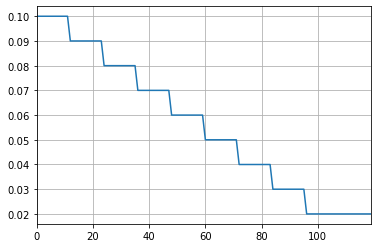

In [28]:
pd.Series(
    proj.lapse_rate(t).loc[1][1] for t in range(120)
).plot.line(legend=False, grid=True)

As a result, the number of policies at any point during the policy term is also the same for all the scenarios. 

<AxesSubplot:>

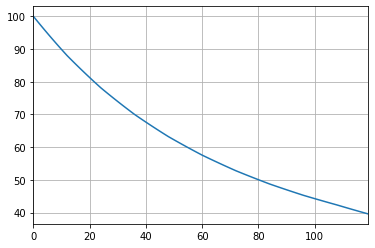

In [29]:
pd.Series(
    proj.pols_if_at(t, 'BEF_DECR').loc[1][1] for t in range(120)
).plot.line(legend=False, grid=True)

Because the lapse rates are deterministic, the number of lapsed policies during any period and the remaining number of remaining policies do not vary by economic scenarios.

In [30]:
proj.pols_maturity(120)

point_id  scen_id
1         1          39.373692
          2          39.373692
          3          39.373692
          4          39.373692
          5          39.373692
                       ...    
          9996       39.373692
          9997       39.373692
          9998       39.373692
          9999       39.373692
          10000      39.373692
Length: 10000, dtype: float64

As with the case for mortality decrement, time value of GMAB is proportional to the number of remaining policy at maturity, and its per policy value is the same as the previous result. 

In [31]:
proj.monte_carlo()

,GMDB,GMAB,GMxB Total,PV Fees,Coverage Ratio
point_id,,,,,
1,600183.568334,648883.71364,1.249067e+06,2.668424e+06,2.136334


## Dynamic lapse assumtpions

Most variable annuity models include dynamic lapse assumptions. A dynamic lapse assumption is used to reflect such policy holder's behaviour that they are more likely to terminate their policies when their account values are larger in comparison to the guaranteed amounts of their policies than they are when the account values are smaller than the guaranteed amounts.
This behaviour is intuitively undestandable and economically rational because the value of guarantee is smaller when the account value is high and vice versa, given the fees are deducted from the account values at a constan rate.

In [32]:
proj.sim_id = 5
proj.is_lapse_dynamic()

True

Here we define In-The-Moneyness(ITM) as cash value per policy divided by the guaranteed amount, which represents a factor that
the dynamic lapse is driven by. Setting up dynamic lapse assumption would take more effort in reality, but here in this example we simply define the dynamic rapse rate as ITM time base deterministic lapse rate.

In [33]:
proj.lapse_rate.formula

def lapse_rate(t):
    """Lapse rate

    By default, the lapse rate assumption is defined by duration as::

        max(0.1 - 0.01 * duration(t), 0.02)

    .. seealso::

        :func:`duration`

    """
    if has_lapse():

        if is_lapse_dynamic():
            factor = csv_pp(t) / sum_assured()
        else:
            factor = 1

        return factor * np.maximum(0.1 - 0.01 * duration(t), 0.02)
    else:
        return pd.Series(0, index=model_point().index)

The graph below shows lapse rates by duration under the first 100 scenarios. The second graph shows the number of policies under the same scenarios. Now the policy decrement is dependent on economic scenarios. 

<AxesSubplot:>

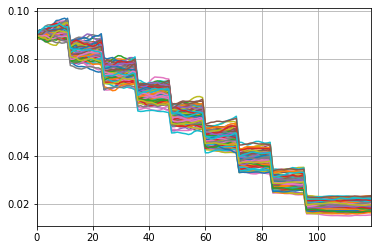

In [34]:
df = pd.DataFrame({t: proj.lapse_rate(t).loc[1][:100] for t in range(120)})
df.transpose().plot.line(legend=False, grid=True)

<AxesSubplot:>

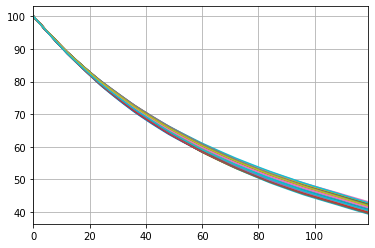

In [35]:
df = pd.DataFrame({t: proj.pols_if_at(t, 'BEF_DECR').loc[1][:100] for t in range(120)})
df.transpose().plot.line(legend=False, grid=True)

The time value of GMDB and GMAB becomes larger than the previous results because of the policyholder behaviour to take advantage of the guarantees. 

In [36]:
proj.monte_carlo()

,GMDB,GMAB,GMxB Total,PV Fees,Coverage Ratio
point_id,,,,,
1,620590.818109,690709.245393,1.311300e+06,2.737674e+06,2.087755


## Summary result

The `Projection` space is parameterized with `sim_id`, so instead of setting a value to `Projection.sim_id`, you can get a space result for the value by a subscription (or call) operation. For example, `Projection[1]` yields a space derived from `Projection` and 1 is set to `sim_id` in that space. `Projection[2]` yields a space derived from `Projection` and 2 is set to `sim_id` in that space, and so on. These spaces are called item spaces and dynamically created by the subscription operations. The have the same definitions of cells and references as the definitions in `Projection`, except for `sim_id`.
Since `Projection` is parameterized with `sim_id`, the values passed in the subscriptions are set to `sim_id` in the dynamic spaces.

The items spaces are useful when you want results for different `sim_id` values at the same time, instead of one result at a time. The `result` cells in the `Summary` space make use of this feature, and it summarizes the results of `monte_carlo` cells of all the 5 `sim_id`.

In [37]:
proj.parameters

('sim_id',)

In [38]:
model.Summary.result.formula

def result():

    data = {sim: Proj[sim].monte_carlo() for sim in range(1, 6)}
    return pd.concat(data, names=["sim_id", "point_id"])

In [39]:
model.Summary.result()

,,GMDB,GMAB,GMxB Total,PV Fees,Coverage Ratio
sim_id,point_id,,,,,
1,1,0.000000,3.338084e+05,3.338084e+05,0.000000e+00,0.000000
2,1,0.000000,1.648013e+06,1.648013e+06,4.286266e+06,2.600868
3,1,833826.665976,1.159486e+06,1.993313e+06,3.728447e+06,1.870477
4,1,600183.568334,6.488837e+05,1.249067e+06,2.668424e+06,2.136334
5,1,620590.818109,6.907092e+05,1.311300e+06,2.737674e+06,2.087755


In [40]:
model.clear_all()
model.close()